<a href="https://www.kaggle.com/sahasprajapati/video-vision-transformer-tfrecord-jester-9-class?scriptVersionId=87110794" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np

import os

In [2]:
import tensorflow as tf
from glob import glob
import pandas as pd
import numpy as np

class TFRecordReader:
    def __init__(self, dir, batch_size, classes, shuffle_buffer_size=512, isRGB=True):
        self.batch_size = batch_size
        self.dir = dir
        self.isRGB = isRGB
        self.shuffle_buffer_size = shuffle_buffer_size
        # label_df = pd.read_csv(label_dir, sep=";", names=["gesture"])
        # self.label_encoder = preprocessing.LabelEncoder()
        # self.label_encoder.fit(label_df["gesture"])
        # print("No of classes:", len(self.label_encoder.classes_))

        self.label_processor = tf.keras.layers.StringLookup(
            num_oov_indices=0, vocabulary=classes,
            mask_token=None 
        )
        self.classes = self.label_processor.vocabulary_size()

       

        self.num_segments = 8
        self.new_length = 4
        self.num_frames = 36
    
    def encode_label(self, label):
        
        label = self.label_processor(label).numpy()
  
        return label

    def parse_tfr_element(self, element):
        data = {
            'n_clips': tf.io.FixedLenFeature([], tf.int64),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth': tf.io.FixedLenFeature([], tf.int64),
            'raw_image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.string),
        }

        content = tf.io.parse_single_example(element, data)

        n_clips = content['n_clips']
        height = content['height']
        width = content['width']
        depth = content['depth']
        raw_image = content['raw_image']
        label = content['label']

        # get out 'feature' --our image and reshape appropriatey
        feature = tf.io.parse_tensor(raw_image, out_type=tf.uint8)
        feature = tf.reshape(feature, shape=[n_clips, height, width, depth])
        if not self.isRGB:
            feature = tf.image.rgb_to_grayscale(feature)
        feature = tf.image.convert_image_dtype(feature, tf.float32)

        label = tf.py_function(self.encode_label, inp=(label,), Tout=tf.int32)

        return (feature, label)

    def get_dataset(self,  pattern:str="*_jester.tfrecords"):

        files = glob(self.dir+pattern, recursive=False)

        dataset = tf.data.TFRecordDataset(files, compression_type="ZLIB")
        dataset = dataset.shuffle(self.shuffle_buffer_size)

        dataset = dataset.map(lambda x: self.parse_tfr_element(x), num_parallel_calls=tf.data.AUTOTUNE)
        # dataset = dataset.filter(lambda x, y: tf.py_function(filter, inp=(x,y), Tout=tf.bool ) )
        # dataset = dataset.map(self._sample_indices)

        dataset = dataset.batch(self.batch_size)
        dataset = dataset.repeat()
        
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset







    def _non_random_indices(self):
        if self.num_frames > self.num_segments + self.new_length - 1:
            tick = (self.num_frames - self.new_length + 1) / float(self.num_segments)
            offsets = np.array([int(tick / 2.0 + tick * x) for x in range(self.num_segments)])
        else:
            offsets = np.zeros((self.num_segments,))
        return offsets + 1
    
    def _random_shift_indices(self):
        average_duration = (self.num_frames - self.new_length + 1) // self.num_segments
        if average_duration > 0:
            offsets = np.multiply(list(range(self.num_segments)), average_duration) + np.random.randint(average_duration,
                                                                                                        size=self.num_segments)
        elif self.num_frames > self.num_segments:
            offsets = np.sort(np.random.randint(self.num_frames - self.new_length + 1, size=self.num_segments))
        else:
            offsets = np.zeros((self.num_segments,))
        return offsets+1

    
    def _get_sampled_indices(self):
        new_indices = []
        #  indices = offsets
        # indices =  _random_shift()
        indices =  self._non_random_indices()
        # print(indices)
        for seg_ind in indices:
            p = int(seg_ind)
            for i in range(self.new_length):
                # seg_imgs = self._load_image(record.path, p)
                # images.extend(seg_imgs)
                new_indices.append(p)
                if p < self.num_frames:
                    p += 1
        return new_indices


    def _sample_indices(self, feature, label):
        indices = self._get_sampled_indices()
        # print("wtf")
        # print(indices)
        return tf.gather(feature, indices=indices), label
        # print(new_inp.shape)
        # print(new_inp)
        # return new_inp
    



In [3]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.patch_size = patch_size
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches
    
    def get_config(self):
        config = super(TubeletEmbedding, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "patch_size": self.patch_size
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [4]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.num_tokens = num_tokens
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        positions = tf.range(start=0, limit=self.num_tokens, delta=1)

        encoded_positions = self.position_embedding(positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens
    def get_config(self):
        return {
            "embed_dim": self.embed_dim,
        }
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [5]:
# DATA
DATASET_NAME = "jester"
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (36, 100, 100, 1) 


# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [6]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=2,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
filter_ges = ["Swiping Down", "Swiping Up", "Swiping Left", "Swiping Right", "Pushing Hand Away", "Pulling Hand In","Turning Hand Clockwise","Turning Hand Counterclockwise", "No gesture"]

In [8]:
BATCH_SIZE = 8
NUM_CLASSES = len(filter_ges)

train_ds_gen = TFRecordReader(dir="../input/jester-tfrecord-9class/train/",batch_size=BATCH_SIZE,shuffle_buffer_size=32,classes=filter_ges, isRGB=False)
train_ds = train_ds_gen.get_dataset()

val_ds_gen = TFRecordReader(dir="../input/jester-tfrecord-9class/validation/",batch_size=BATCH_SIZE, shuffle_buffer_size=32,classes=filter_ges, isRGB=False)
val_ds = val_ds_gen.get_dataset()

print(f"TRAIN Class:{train_ds_gen.classes} VAL Class:{val_ds_gen.classes}")

2022-02-06 10:29:32.718132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 10:29:32.842974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 10:29:32.843714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 10:29:32.844870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

TRAIN Class:9 VAL Class:9


In [9]:
model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
        num_classes=NUM_CLASSES
    )

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 36, 100, 100 0                                            
__________________________________________________________________________________________________
tubelet_embedding (TubeletEmbed (None, 576, 128)     65664       input_1[0][0]                    
__________________________________________________________________________________________________
positional_encoder (PositionalE (None, 576, 128)     73728       tubelet_embedding[0][0]          
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 576, 128)     256         positional_encoder[0][0]         
______________________________________________________________________________________________

In [11]:
# Instantiate an optimizer to train the model.
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# Instantiate a loss function.
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
train_top5_acc_metric = keras.metrics.SparseTopKCategoricalAccuracy(k=5)
# val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
filepath ="./checkpoint"
checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

In [12]:
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=[train_acc_metric, train_top5_acc_metric])

In [13]:
# model.load_weights(filepath)

In [14]:
# Classes 9
steps_per_epoch = np.ceil(36297/ train_ds_gen.batch_size)
val_steps_per_epoch = np.ceil(4389/ val_ds_gen.batch_size)
# Classees3
# steps_per_epoch = np.ceil(12524/ train_ds_gen.batch_size)
# val_steps_per_epoch = np.ceil(1513/ val_ds_gen.batch_size)

model.fit(
        train_ds,
        validation_data=val_ds,
        steps_per_epoch = steps_per_epoch,
        validation_steps=val_steps_per_epoch,
        callbacks=[checkpoint],
        epochs=10
)

2022-02-06 10:29:36.577875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-02-06 10:29:46.219855: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4538/4538 [==============================] - 868s 188ms/step - loss: 2.2175 - sparse_categorical_accuracy: 0.1194 - sparse_top_k_categorical_accuracy: 0.5745 - val_loss: 2.2007 - val_sparse_categorical_accuracy: 0.1335 - val_sparse_top_k_categorical_accuracy: 0.6104

Epoch 00001: val_loss improved from inf to 2.20067, saving model to ./checkpoint
Epoch 2/10
4538/4538 [==============================] - 878s 193ms/step - loss: 1.7959 - sparse_categorical_accuracy: 0.3000 - sparse_top_k_categorical_accuracy: 0.7736 - val_loss: 1.4810 - val_sparse_categorical_accuracy: 0.4498 - val_sparse_top_k_categorical_accuracy: 0.8982

Epoch 00002: val_loss improved from 2.20067 to 1.48100, saving model to ./checkpoint
Epoch 3/10
4538/4538 [==============================] - 886s 195ms/step - loss: 1.4117 - sparse_categorical_accuracy: 0.4762 - sparse_top_k_categorical_accuracy: 0.9095 - val_loss: 1.3871 - val_sparse_categorical_accuracy: 0.4755 - val_sparse_top_k_categorical_accuracy: 0.9271

Epoch 00

In [15]:
model.save( os.path.join(os.getcwd(),  "saved_model", "classes9_model"))

2022-02-06 12:58:35.721713: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [16]:
loaded_model = tf.keras.models.load_model(os.path.join(os.getcwd(),  "saved_model", "classes9_model"))

In [17]:
images, labels  = next(iter(val_ds))

In [18]:

pred = loaded_model.predict(images)

pred_gesture = np.argmax(pred, axis=1)

In [19]:
print(pred_gesture)

[3 5 0 3 6 4 0 5]


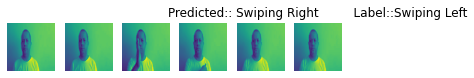

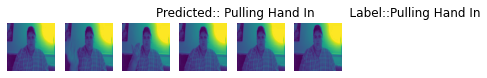

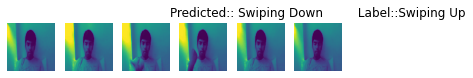

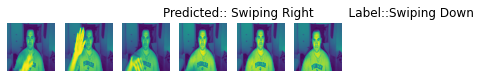

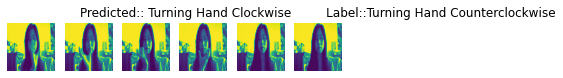

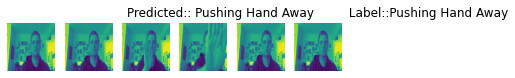

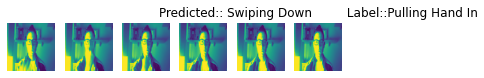

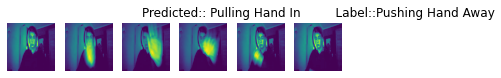

In [20]:
import matplotlib.pyplot as plt
filter_ges = ["Swiping Down", "Swiping Up", "Swiping Left", "Swiping Right", "Pushing Hand Away", "Pulling Hand In","Turning Hand Clockwise","Turning Hand Counterclockwise", "No gesture"]

for i in range(8):
    fig, axs = plt.subplots(1, 6)
    for j in range(6):

        axs[ j].imshow(images[i][(j+1)*6-1])
        axs[j].axis("off")
        # axs[ j].set_title(f'{filter_ges[pred_gesture[i]]}')
    plt.title(f'Predicted:: {filter_ges[pred_gesture[i]]}         Label::{filter_ges[labels[i]]}')
 
    plt.show()



In [21]:
%pip install tensorflowjs

     |████████████████████████████████| 77 kB 933 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77048 sha256=c61c250a23acf7b0b9e1bdeb9949c9c8611f8cce85ae7c7f0f28d0d9486319a8
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Successfully uninstalled wrapt-1.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are i

In [22]:
import tensorflowjs as tfjs

In [23]:
tfjs.converters.convert_tf_saved_model(os.path.join(os.getcwd(),  "saved_model", "classes9_model"), os.path.join(os.getcwd(),  "saved_model", "tfjs", "classes9_model") )

2022-02-06 13:02:46.446054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 13:02:46.446562: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-02-06 13:02:46.447995: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-02-06 13:02:46.449594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 13:02:46.449977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 13:02:46.450336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

Writing weight file /kaggle/working/saved_model/tfjs/classes9_model/model.json...
